In [1]:
# Marina Reggiani-Guzzo
# Nov, 2021

In [2]:
# fix window size, jupyter width = 100% page width
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))

#test 
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

from numpy import asarray

# ===================== #
# libraries for the BDT #
# ===================== #

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost
from xgboost import XGBClassifier

pd.options.display.max_columns = None 

In [3]:
# create "plots" directory
import os
if(os.path.isdir('plots')==False):
    os.makedirs('plots')
    print('Making folder "plots".')
else: print('The folder "plots" already exists!')

The folder "plots" already exists!


### General Functions

In [4]:
# ======================== #
#                          #
#   ACTIVE VOLUME LIMITS   #
#                          #
# ======================== #

# unit = cm
tpc_xmin = 0
tpc_xmax = 254.3
tpc_ymin = -115.0
tpc_ymax = 117.0
tpc_zmin = 0.6
tpc_zmax = 1036.4

# ====================== #
#                        #
#    CREATE DATAFRAME    #
#                        #
# ====================== #

def create_dataframe(file, family):
    
    # ------------ #
    # import trees #
    # ------------ # 
    
    T_pot = uproot.open(file)['wcpselection/T_pot']
    T_KINE = uproot.open(file)['wcpselection/T_KINEvars']
    T_BDT = uproot.open(file)['wcpselection/T_BDTvars']
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    T_eval = uproot.open(file)['wcpselection/T_eval']
    
    # --- create reco dataframes
    df_pot_reco    = T_pot.pandas.df(pot_vars_reco, flatten=False)
    df_KINE_reco   = T_KINE.pandas.df(kine_vars_reco, flatten=False)
    df_BDT_reco    = T_BDT.pandas.df(bdt_vars_reco, flatten=False)
    df_PFeval_reco = T_PFeval.pandas.df(pfeval_vars_reco, flatten=False)
    df_eval_reco   = T_eval.pandas.df(eval_vars_reco, flatten=False)    
    
    df = pd.concat([df_KINE_reco, df_BDT_reco, df_PFeval_reco, df_eval_reco], axis=1)
    
    # --- create truth dataframes
    if((family=='MC') | (family=='NUE')):
        df_pot_true    = T_pot.pandas.df(pot_vars_true, flatten=False)
        df_KINE_true   = T_KINE.pandas.df(kine_vars_true, flatten=False)
        df_BDT_true    = T_BDT.pandas.df(bdt_vars_true, flatten=False)
        df_PFeval_true = T_PFeval.pandas.df(pfeval_vars_true, flatten=False)
        df_eval_true   = T_eval.pandas.df(eval_vars_true, flatten=False)
        
        df = pd.concat([df, df_KINE_true, df_BDT_true, df_PFeval_true, df_eval_true], axis=1)
        
    # ----------------------------------------------------------------- #
    #  fix weight_cv and weight_spline (only overlay and intrinsic nue) #
    # ----------------------------------------------------------------- #
    
    if((family=='MC') | (family=='NUE')):
        df['weight_cv'] = np.where((df.weight_cv <= 0), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv > 30), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.nan), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.inf), 1, df.weight_cv)
        df['weight_cv'] = np.where((df['weight_cv'].isna()), 1, df.weight_cv)
        df['weight_spline'] = np.where((df.weight_spline <= 0), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline > 30), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.nan), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.inf), 1, df.weight_spline)
        df['weight_spline'] = np.where((df['weight_spline'].isna()), 1, df.weight_spline)
                
    # ------------- #
    # fix nue_score #
    # ------------- #
    
    df['nue_score'] = np.where((df.nue_score == np.inf), 16, df.nue_score)
    df['nue_score'] = np.where((df.nue_score == -np.inf), -16, df.nue_score)   
    
    # ------------------------ #
    # calculate POT and weight #
    # ------------------------ #
    
    POT_tot = 0
    W_ = 1
    
    if((family=='MC') | (family=='NUE')): 
        POT_tot = sum(df_pot_reco.pot_tor875)
        if(POT_tot!=0): W_ = POT_data/POT_tot # <--- up to here calculated
        elif(POT_tot==0): W_ = 1
        df.loc[:,'weight_genie'] = df['weight_cv']*df['weight_spline']
        df.loc[:,'weight'] = [W_]*df.shape[0]*df['weight_genie']
        
    elif(family=='DATA'): 
        POT_tot = POT_data
        W_ = 1
        df.loc[:,'weight'] = [W_]*df.shape[0]
        
    elif(family=='EXT'): 
        POT_tot = POT_ext
        W_ = (POT_data/POT_tot)*0.98   # 0.98 = NuMI correction factor
        df.loc[:,'weight'] = [W_]*df.shape[0]

    # ------------------- #
    # add extra variables #
    # ------------------- #
    
    df = calc_costheta(df)  # cos_theta of the shower wrt the NuMI beam direction
    
    if((family=='MC') | (family=='NUE')): 
        # new variables that depend on true information should be here
        df = calc_vtx_reco_true_dist(df)    
    
    # -------------------------------------- #
    # delete dataframes to save memory space #
    # -------------------------------------- #
    
    del df_pot_reco
    del df_KINE_reco
    del df_BDT_reco 
    del df_PFeval_reco
    del df_eval_reco
    
    if((family=='MC') | (family=='NUE')):
        del df_pot_true
        del df_KINE_true
        del df_BDT_true
        del df_PFeval_true
        del df_eval_true    
        
    print('[%s] POT %5.2e      %7i entries' % (family,POT_tot,len(df)))

    return df, POT_tot

# ========================================= #
#                                           #
#    FUNCTIONS TO CREATE EXTRA VARIABLES    #
#                                           #
# ========================================= #

def calc_costheta(df):
    
    # position of the NuMI target
    # those values are manually added to the lines below
    # if you want to change them, make sure you also update the lines below!!
    v_targ_uboone = [-31387.58422, -3316.402543, -60100.2414]

    # take the vector from the NuMI target to the neutrino vertex
    df.eval('vec_targ_vtx_X = reco_nuvtxX - (-31387.58422)', inplace=True)
    df.eval('vec_targ_vtx_Y = reco_nuvtxY - (-3316.402543)', inplace=True)
    df.eval('vec_targ_vtx_Z = reco_nuvtxZ - (-60100.2414)', inplace=True)
    
    # get reco shower vector (workaround that is working, for some reason I can't access it if I don't do this workaround, maybe it's somethind to do with the name containing [ ])
    df.loc[:,'shower_momentum_X'] = df["reco_showerMomentum[0]"]
    df.loc[:,'shower_momentum_Y'] = df["reco_showerMomentum[1]"]
    df.loc[:,'shower_momentum_Z'] = df["reco_showerMomentum[2]"]
    df.loc[:,'shower_energy'] = df["reco_showerMomentum[3]"]
    
    # calculate the norm of the vectors
    df.eval('norm_vec_targ_vtx = sqrt(vec_targ_vtx_X**2 + vec_targ_vtx_Y**2 + vec_targ_vtx_Z**2)', inplace=True)
    df.eval('norm_vec_shower = sqrt(shower_momentum_X**2 + shower_momentum_Y**2 + shower_momentum_Z**2)', inplace=True)
    
    # calculate cos_theta
    df.eval('cos_theta = ((vec_targ_vtx_X * shower_momentum_X) + (vec_targ_vtx_Y * shower_momentum_Y) + (vec_targ_vtx_Z * shower_momentum_Z) )/(norm_vec_targ_vtx * norm_vec_shower)', inplace=True)

    return df

def calc_vtx_reco_true_dist(df):
    df_copy = df.copy()
    df_copy.eval('dist_vtxX = reco_nuvtxX - truth_corr_nuvtxX', inplace=True)
    df_copy.eval('dist_vtxY = reco_nuvtxY - truth_corr_nuvtxY', inplace=True)
    df_copy.eval('dist_vtxZ = reco_nuvtxZ - truth_corr_nuvtxZ', inplace=True)
    df_copy.eval('dist_vtx = sqrt(dist_vtxX**2 + dist_vtxY**2 + dist_vtxZ**2)', inplace=True)
    return df_copy

# ======================== #
#                          #
#   APPLY SELECTION CUTS   #
#                          #
# ======================== #

def applyCuts(label, dfData, dfEXT, dfIntrinsicNue, dfOverlay, count, cut, print_lengths, make_plots):
    
    # cut = BDT score cut used for label=BDT1_nina only, set the rest to -1
    # print_lengths = print the number of entries after the cut (True/False)
    # make_plots = create a pdf with the plots
    
    print('\n---------- Applying: %s' % label)
    
    # ----- apply the cuts to the input dataframes
    
    if((label=='None')):
        print('           No cuts applied')
        # don't do anything with the dataframe, so basically the applyCuts function
        # is being called to draw the histograms at this specific stage of the selection
        # cuts
        df_data = dfData
        df_ext = dfEXT
        df_intrinsic_nue = dfIntrinsicNue
        df_overlay = dfOverlay        
    elif(label=='GenNuSelection'):
        print('           Guarantees a Reconstructed Neutrino\n')
        # generic neutrino selection
        # guarantees a reconstructed neutrino
        df_data = apply_gen_nu_selection(dfData)
        df_ext = apply_gen_nu_selection(dfEXT)
        df_intrinsic_nue = apply_gen_nu_selection(dfIntrinsicNue)
        df_overlay = apply_gen_nu_selection(dfOverlay)
    elif(label=='inFV'):
        print('           Neutrino Reconstructed Vertex inFV\n')
        # neutrino reconstructed vertex inFV
        df_data = apply_inFV(dfData)
        df_ext = apply_inFV(dfEXT)
        df_intrinsic_nue = apply_inFV(dfIntrinsicNue)
        df_overlay = apply_inFV(dfOverlay)
    elif(label=='ShowerCut'):
        print('           Guarantees a Reconstructed Shower\n')
        # guarantees a reconstructed shower 
        # important for my analysis as cos_theta depends on a reco shower
        df_data = apply_showerCut(dfData)
        df_ext = apply_showerCut(dfEXT)
        df_intrinsic_nue = apply_showerCut(dfIntrinsicNue)
        df_overlay = apply_showerCut(dfOverlay)
    elif(label=='BDT1_nina'):
        # in this case, use my BDT to select nue+antinue
        df_data = dfData[dfData.bdt_score>cut]
        df_ext = dfEXT[dfEXT.bdt_score>cut]
        df_overlay = dfOverlay[dfOverlay.bdt_score>cut]
        df_intrinsic_nue = dfIntrinsicNue[dfIntrinsicNue.bdt_score>cut]
    elif(label=='BDT1_wirecell'):
        print('           Applies the wirecell nue+antinue score cut\n')
        # use the BDT score developed by wirecell to select nue+antinue
        df_data = isRecoNueCCWC(dfData)
        df_ext = isRecoNueCCWC(dfEXT)
        df_overlay = isRecoNueCCWC(dfOverlay)
        df_intrinsic_nue = isRecoNueCCWC(dfIntrinsicNue)
    elif(label=='outFV'):
        df_data = apply_outFV(dfData) # Holly
        
    # if you want to include a new cut, simply add it to the list below, to the commented out block
    #elif(label=='NewCut'): 
        #df_data = apply_newcut(dfData)
        #df_ext = apply_newcut(dfEXT)
        #df_intrinsic_nue = apply_newcut(dfIntrinsicNue)
        #df_overlay = apply_newcut(dfOverlay)
        
    # calculate the number of entries DATA POT normalised
    nentries_data_POT = len(df_data)
    nentries_ext_POT = len(df_ext)*(POT_data/POT_ext)
    nentries_nue_POT = len(df_intrinsic_nue)*(POT_data/POT_nue)
    nentries_mc_POT = len(df_overlay)*(POT_data/POT_mc)
    if(print_lengths==True):
        print('Number of entries:')
        print('[DATA] %7i (absolute)  %10i (DATA POT normalised)' % (len(df_data), nentries_data_POT))
        print('[EXT]  %7i (absolute)  %10i (DATA POT normalised)' % (len(df_ext), nentries_ext_POT))
        print('[NUE]  %7i (absolute)  %10i (DATA POT normalised)' % (len(df_intrinsic_nue), nentries_nue_POT))
        print('[MC]   %7i (absolute)  %10i (DATA POT normalised)' % (len(df_overlay), nentries_mc_POT))
        print('')
        
    # ----- save the number of entries per dataframe
    arr_nentries_nue.append(nentries_nue_POT)
    arr_nentries_mc.append(nentries_mc_POT)
    arr_nentries_data.append(nentries_data_POT)
    arr_nentries_ext.append(nentries_ext_POT)
    arr_nentries_x.append(count)
    arr_nentries_x_label.append(label)
    
    count = count+1
    
    # make stacked histograms
    if(make_plots == True):
        plots_for_SelectionCuts(df_data, df_ext, df_intrinsic_nue, df_overlay, label)
        
    # return the updated dataframes
    return df_data, df_ext, df_intrinsic_nue, df_overlay, count 

def apply_gen_nu_selection(df):    
    # the generic neutrino selection guarantees that there is a reconstructed neutrino
    df_ = df[df.numu_cc_flag >= 0]
    return df_

def apply_inFV(df):
    dist = 3 # distance from the boundaries
    df_ = df[((df.reco_nuvtxX>(tpc_xmin+dist)) & (df.reco_nuvtxX<(tpc_xmax-dist))) &
             ((df.reco_nuvtxY>(tpc_ymin+dist)) & (df.reco_nuvtxY<(tpc_ymax-dist))) &
             ((df.reco_nuvtxZ>(tpc_zmin+dist)) & (df.reco_nuvtxZ<(tpc_zmax-dist)))]    
    return df_

def apply_showerCut(df):    
    # this cut guarantees that there is a reconstructed shower
    # shower_vtxX = shower_vtxY = shower_vtxZ = shower_energy = -1 for events without a reconstructed shower
    # so it is safe to select shower_energy!=-1 since shower_energy==-1 is not a physical quantity
    df_ = df[df.shower_energy!=-1] 
    return df_

''' # Holly
def apply_outFV(df):
    dist = 3
    df_ = #make the cut here
    return df_
'''

# ======================================== #
#                                          #
#   LIST OF PLOTS FOR THE SELECTION CUTS   #
#                                          #
# ======================================== #

def plots_for_SelectionCuts(df_data, df_ext, df_intrinsic_nue, df_overlay, label):
    
    # this function makes all the plots that you want to plot throughout the pre-selection cuts
    
    # --- MC/DATA comparison
       
    dist = 15
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxX", "plots/%s_nuvtxX" % label, "Reco neutrino Vertex X [cm]", tpc_xmin-dist, tpc_xmax+dist, 25, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxY", "plots/%s_nuvtxY" % label, "Reco neutrino Vertex Y [cm]", tpc_ymin-dist, tpc_ymax+dist, 25, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxZ", "plots/%s_nuvtxZ" % label, "Reco neutrino Vertex Z [cm]", tpc_zmin-dist, tpc_zmax+dist, 25, POT_data)
    
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "flash_time", "plots/%s_flash_time" % label, r"Flash Time [$\mu$s]", 4, 18, 50, POT_data)
    
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "cos_theta", "plots/%s_costheta" % label, r"cos($\theta$)", -1.2, 1.2, 25, POT_data)
    
    # variables used for the BDT -- check if they make sense
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "kine_reco_Enu", "plots/%s_kine_reco_Enu" % label, "Reco Neutrino Energy [MeV]", 0, 1600, 30, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "kine_pio_vtx_dis", "plots/%s_kine_pio_vtx_dis" % label, r"$\pi^0$ Vertex Distance [cm]", 0, 200, 30, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "kine_pio_energy_1", "plots/%s_kine_pio_energy_1" % label, r"$\pi^0$ Reco Energy [MeV]", 0, 1000, 30, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "numu_cc_flag", "plots/%s_numu_cc_flag" % label, "Reco Neutrino Energy [MeV]", -1, 1, 10, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "nue_score", "plots/%s_nue_score" % label, "nue_score", -20, 20, 40, POT_data)
    
    # add here if you want to plot new variables, Holly
    
def isTopo_reco(df):
    df_ = df # don't apply any reconstructed topology
    #df_ = df[(df.numu_cc_flag>=0) & (df.nue_score>7)]  # nue+antinueCC for wirecell
    return df_

def isRecoNueCCWC(df):
    df_ = df[(df.numu_cc_flag>=0) & (df.nue_score>7)]
    return df_
    
def plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, var, filename, xaxis, xmin, xmax, nbins, POT_DATA):
    
    print('Plotting stacked histogram: %s' % xaxis)
    
    plt.close() # close figure to save memory    
    
    # ----- restrict the dataframes to the range that is going to be displayed 
    
    df_overlay = df_overlay[(df_overlay[var]>=xmin) & (df_overlay[var]<=xmax)]
    df_intrinsic_nue = df_intrinsic_nue[(df_intrinsic_nue[var]>=xmin) & (df_intrinsic_nue[var]<=xmax)]
    df_data = df_data[(df_data[var]>=xmin) & (df_data[var]<=xmax)]
    df_ext = df_ext[(df_ext[var]>=xmin) & (df_ext[var]<=xmax)]
        
    # ----- get the number of entries
    
    n_overlay = len(df_overlay)
    n_intrinsic_nue = len(df_intrinsic_nue)
    n_data = len(df_data)
    n_ext = len(df_ext)
    
    # ----- check if the events are uniquely classified
    #check_classification_multiplicity(df_overlay, 'Overlay')
    
    # ----- get TRUE topologies
    
    # cosmic
    df_cosmic = isCosmic(df_overlay)
    n_cosmic = len(df_cosmic)
    df_overlay = delete_dataframe(df_overlay,df_cosmic) # delete overlay and bad reconstructed events

    # outFV
    df_outFV = isOutFV(df_overlay)
    n_outFV = len(df_outFV)
    df_overlay = delete_dataframe(df_overlay,df_outFV) # exclude events outside the FV

    # numuCCpi0
    df_numuCCpi0 = isNumuCCpi0(df_overlay)
    n_numuCCpi0 = len(df_numuCCpi0)

    # numuCC
    df_numuCC = isNumuCC(df_overlay)
    n_numuCC = len(df_numuCC)

    # NCpi0
    df_ncpi0 = isNCpi0(df_overlay)
    n_ncpi0 = len(df_ncpi0)

    # NC
    df_nc = isNC(df_overlay)
    n_nc = len(df_nc)
    
    # nueCC
    # not used for the stacked histogram, only checking if all events
    df_nueCC = isNueCC(df_overlay)
    n_nueCC = len(df_nueCC)
    
    # nuebarCC
    df_nuebarCC = isNuebarCC(df_overlay)
    n_nuebarCC = len(df_nuebarCC)

    #print('\nOverlay (%i entries)' % n_overlay)
    #print('Cosmic    %10i' % n_cosmic)
    #print('outFV     %10i' % n_outFV)
    #print('NumuCCpi0 %10i' % n_numuCCpi0)
    #print('NumuCC    %10i' % n_numuCC)
    #print('NCpi0     %10i' % n_ncpi0)
    #print('NC        %10i' % n_nc)
    #print('NueCC     %10i' % n_nueCC)
    #print('NuebarCC  %10i' % n_nuebarCC)
    #print('Total     %10i' % (n_cosmic + n_outFV + n_numuCCpi0 + n_numuCC + n_ncpi0 + n_nc + n_nueCC + n_nuebarCC))
    
    # nueCC
    df_nueCC = isNueCC(df_intrinsic_nue)
    n_nueCC = len(df_nueCC)

    # nuebarCC
    df_nuebarCC = isNuebarCC(df_intrinsic_nue)
    n_nuebarCC = len(df_nuebarCC)
    
    #print('\nIntrinsic Nue (%i entries)' % n_intrinsic_nue)
    #print('NueCC     %10i' % n_nueCC)
    #print('NuebarCC  %10i' % n_nuebarCC) 
    #print('Total     %10i' % (n_nueCC + n_nuebarCC))
    
    # get entries
    hist_list = [isTopo_reco(df_cosmic)[var],
                 isTopo_reco(df_outFV)[var],
                 isTopo_reco(df_numuCCpi0)[var],
                 isTopo_reco(df_numuCC)[var],
                 isTopo_reco(df_ncpi0)[var],
                 isTopo_reco(df_nc)[var],
                 isTopo_reco(df_nueCC)[var],
                 isTopo_reco(df_nuebarCC)[var],
                 isTopo_reco(df_ext)[var]]

    hist_data = isTopo_reco(df_data)[var]

    # weights
    w_list = [isTopo_reco(df_cosmic).weight,
              isTopo_reco(df_outFV).weight,
              isTopo_reco(df_numuCCpi0).weight,
              isTopo_reco(df_numuCC).weight,
              isTopo_reco(df_ncpi0).weight,
              isTopo_reco(df_nc).weight,
              isTopo_reco(df_nueCC).weight,
              isTopo_reco(df_nuebarCC).weight,
              isTopo_reco(df_ext).weight]

    w_data = isTopo_reco(df_data).weight
    
    # colors
    c_list = ['paleturquoise',
              'springgreen',
              'limegreen',
              'aqua',
              'orange',
              'saddlebrown',
              'grey',
              'brown',
              'gold']

    c_data = 'black'

    # labels
    label_list = ['Cosmic (%1.1f)'%(sum(w_list[0])),
                  'outFV (%1.1f)'%(sum(w_list[1])),
                  r'$\nu_{\mu}$ CC $\pi^{0}$ (%1.1f)'%(sum(w_list[2])),
                  r'$\nu_{\mu}$ CC (%1.1f)'%(sum(w_list[3])),
                  r'NC $\pi^{0}$ (%1.1f)'%(sum(w_list[4])),
                  'NC (%1.1f)'%(sum(w_list[5])),
                  r'$\nu_{e}$ CC (%1.1f)'%(sum(w_list[6])),
                  r'$\bar{\nu}_{e}$ CC (%1.1f)'%(sum(w_list[7])),
                  'EXT (%1.1f)'%(sum(w_list[8]))]

    label_data = 'Data (%1.1f)'%(sum(w_data))

    # ========== stacked histogram
    
    legend_size = 12
    xrange = (xmin ,xmax) 
    axis_label_size = 18
    ticks_size = 14

    # configure the canvas
    fig, axs = plt.subplots(2, 1, figsize=(10,10), gridspec_kw=dict(height_ratios=[4,1]), sharex=True)
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, # position of top part of the top pad
                        wspace=0.2, 
                        hspace=0.1) # distance between plots
    
    # plot stacked histogram
    hist_stacked, bins_stacked, counts_stacked = axs[0].hist(hist_list, bins=nbins, range=(xmin,xmax), weights=w_list, color=c_list, label=label_list, stacked=True)     
    data_hist, bins_ = np.histogram(hist_data, weights=w_data, bins=nbins, range=xrange)
    err_bar = [np.sqrt(x) for x in data_hist]
    mid = 0.5*(bins_[1:] + bins_[:-1])
    axs[0].errorbar(mid, data_hist, xerr=0.5*xrange[1]/nbins, yerr=err_bar, color=c_data, label=label_data, fmt='o')   
    
    # get the histograms individually
    hist8 = axs[1].hist(hist_list[8], bins=nbins, weights=w_list[8], range=xrange, color=c_list[8], label=label_list[8], stacked=True) # EXT
    hist7 = axs[1].hist(hist_list[7], bins=nbins, weights=w_list[7], range=xrange, color=c_list[7], label=label_list[7], stacked=True) # nuebarCC
    hist6 = axs[1].hist(hist_list[6], bins=nbins, weights=w_list[6], range=xrange, color=c_list[6], label=label_list[6], stacked=True) # nueCC
    hist5 = axs[1].hist(hist_list[5], bins=nbins, weights=w_list[5], range=xrange, color=c_list[5], label=label_list[5], stacked=True) # NC
    hist4 = axs[1].hist(hist_list[4], bins=nbins, weights=w_list[4], range=xrange, color=c_list[4], label=label_list[4], stacked=True) # NCpi0
    hist3 = axs[1].hist(hist_list[3], bins=nbins, weights=w_list[3], range=xrange, color=c_list[3], label=label_list[3], stacked=True) # numuCC
    hist2 = axs[1].hist(hist_list[2], bins=nbins, weights=w_list[2], range=xrange, color=c_list[2], label=label_list[2], stacked=True) # numuCCpi0
    hist1 = axs[1].hist(hist_list[1], bins=nbins, weights=w_list[1], range=xrange, color=c_list[1], label=label_list[1], stacked=True) # outFV
    hist0 = axs[1].hist(hist_list[0], bins=nbins, weights=w_list[0], range=xrange, color=c_list[0], label=label_list[0], stacked=True) # cosmic
    axs[1].clear() # clear the axis so we can simply plot the ratio
    
    # ========== ratio
    
    # calculate ratio
    ratio = []
    ratio_stat = []
    ratio_error_sqrt = []
    ratio_center = []
    
    mc_total = []   # number of entries
    mc_stat = []    # stat error
    
    data_total = [] # number of entries
    data_stat = []  # stat error
    
    for i in range(0,nbins): 
        
        # get total entries
        mc_total.append(hist0[0][i] + hist1[0][i] + hist2[0][i] + hist3[0][i] + hist4[0][i] + hist5[0][i] + hist6[0][i] + hist7[0][i] + hist8[0][i])
        data_total.append(data_hist[i])
        
        # calculate stat uncertainties
        mc_stat.append(np.sqrt(mc_total[i]))
        data_stat.append(np.sqrt(data_total[i]))
        
        # calculate ratio: Data/MC
        if(mc_total[i]!=0): ratio.append(data_total[i]/mc_total[i])
        else: ratio.append(0)
        
        ratio_center.append(1) # ratio should be centered at 1
        
        # calculate ratio uncertainty
        if(mc_total[i]!=0): 
            ratio_stat_first = ((data_stat[i]/mc_total[i])**2)+(((data_total[i]*mc_stat[i])/(mc_total[i]**2))**2)  # before taking the sqrt
            ratio_stat.append(np.sqrt(ratio_stat_first))
        #if(mc_total[i]!=0): ratio_stat.append(np.sqrt(data_total[i])/mc_total[i])
        else: ratio_stat.append(0)
        
    # plot ratio    
    axs[1].plot(mid, ratio, marker='o', color='black', linewidth=0)
    
    # plot ratio stat uncertainty (bar)
    err_bar = [x for x in ratio_stat]
    axs[1].errorbar(mid, ratio, xerr=0.5*xrange[1]/nbins, yerr=err_bar, color=c_data, label=label_data, fmt='o')
    
    # ========== draw gray area error
    
    # for the stacked histogram
    # the gray area error represents the MC stat uncertainty
    upvals = np.append((np.array(mc_total)+np.array(mc_stat)),(np.array(mc_total)+np.array(mc_stat))[-1])
    lowvals = np.append((np.array(mc_total)-np.array(mc_stat)),(np.array(mc_total)-np.array(mc_stat))[-1])
    axs[0].fill_between(bins_, lowvals, upvals, step='post', color='gray', alpha=0.3, zorder=2)
    
    # for the ratio
    # the gray area error represents the ratio stat uncertainty, that was calculated by propagating the uncertainty
    upvals = np.append((np.array(ratio_center)+np.array(ratio_stat)),(np.array(ratio_center)+np.array(ratio_stat))[-1])
    lowvals = np.append((np.array(ratio_center)-np.array(ratio_stat)),(np.array(ratio_center)-np.array(ratio_stat))[-1])
    axs[1].fill_between(bins_, lowvals, upvals, step='post', color='gray', alpha=0.3, zorder=2)
    
    # ========== final touch on the appearance
    
    # top pad
    axs[0].set_ylim(bottom=0)
    axs[0].legend(loc='best', ncol=3, prop={'size': 12})
    axs[0].set_ylabel('Entries', size=axis_label_size, loc='top')
    axs[0].set_title(r'MicroBooNE NuMI Data: %1.1e POT' % POT_DATA, size=20, loc='left')
    axs[0].xaxis.set_tick_params(labelsize=ticks_size)
    axs[0].yaxis.set_tick_params(labelsize=ticks_size)
    # find the maximum to make space for the legend (multiply max by 1.5)
    max_data = np.max(data_total)
    max_mc = np.max(mc_total)
    max_all = 0
    if(max_data>max_mc): max_all = max_data
    else: max_all = max_mc
    axs[0].set_ylim((0,max_all*1.5))
    
    # bottom pad
    axs[1].set_ylabel('Data/MC', size=axis_label_size, loc='center')
    axs[1].set_xlabel('%s' % xaxis, size=axis_label_size)
    axs[1].xaxis.set_tick_params(labelsize=ticks_size)
    axs[1].yaxis.set_tick_params(labelsize=ticks_size)
    axs[1].set_ylim([0.9, 1.1])
    
    # draw horizontal line at y=1
    x_values = [xmin,xmax]
    y_values = [1,1]
    axs[1].plot(x_values, y_values, color='black', linestyle='dashed')  
    
    # ========== save plot
    
    plt.savefig('%s.pdf' % filename)
    #plt.show(0)
    
# =================== #
#                     #
#   TRUE TOPOLOGIES   #
#                     #
# =================== #

def isCosmic(df):
    df_ = df[((df.match_completeness_energy <= df.truth_energyInside * 0.1) | (df.truth_energyInside <= 0))]
    return df_

def notCosmic(df):
    df_ = df[((df.match_completeness_energy > df.truth_energyInside * 0.1) & (df.truth_energyInside > 0))]
    return df_

def isOutFV(df):
    df_ = df[(df.truth_vtxInside==0)]                            # vtx outFV
    return df_

def isNueCC(df):
    df_ = df[(df.truth_nuPdg==12) &                              # nue
             (df.truth_isCC==1)]                                 # CC
    return df_

def isNuebarCC(df):
    df_ = df[(df.truth_nuPdg==-12) &                             # nuebar
             (df.truth_isCC==1)]                                 # CC
    return df_

def isNumuCCpi0(df):
    df_ = df[((df.truth_nuPdg==14) | (df.truth_nuPdg==-14)) &    # numu
             (df.truth_isCC==1) &                                # CC
             (df.truth_NprimPio>0)]                              # with pi0
    return df_

def isNumuCC(df):
    df_ = df[((df.truth_nuPdg==14) | (df.truth_nuPdg==-14)) &    # numu
             (df.truth_isCC==1) &                                # CC
             (df.truth_NprimPio<=0)]                             # without pi0 (to avoid overlap with the topology above)
    return df_

def isNCpi0(df):
    df_ = df[(df.truth_isCC==0) &                                # NC
             (df.truth_NprimPio>0)]                              # with pi0
    return df_

def isNC(df):
    df_ = df[(df.truth_isCC==0) &                                # NC
             (df.truth_NprimPio<=0)]                             # without pi0 (to avoid overlap with the topology above)
    return df_

# ===================== #
#                       #
#   UTILITY FUNCTIONS   #
#                       #
# ===================== #

def delete_dataframe(df1,df2):
    # delete df2 from df1
    df_ = pd.concat([df1,df2,df2]).drop_duplicates(keep=False)
    return df_

# ================= #
#                   #
#   FINAL MESSAGE   #
#                   #
# ================= #

print('All done.')

All done.


# Welcome to the Code! :)

## Define Dataframes (DATA, EXT, Intrinsic Nue, Overlay)

In [5]:
# =============== #
#                 #
#   INPUT FILES   #
#                 #
# =============== #

# files can be found here: https://www.phy.bnl.gov/xqian/talks/wire-cell/LEEana/processed_checkout_rootfiles/

datafile = '/uboone/data/users/mguzzo/wirecell/checkout_data_numi_run1_full_FHC.root'                                       # data = beam-on
extfile = '/uboone/data/users/mguzzo/wirecell/checkout_data_extnumi_run1.root'                                              # ext = beam-off
mcfile = '/uboone/data/users/mguzzo/wirecell/checkout_prodgenie_numi_nu_overlay_run1.root'                                  # intrinsice nue = nue + antinue (only)  --> with particle flow information
intrinsicfile = '/uboone/data/users/mguzzo/wirecell/checkout_prodgenie_numi_intrinsic_nue_overlay_run1.root'                # MC = numu + antinumu + nue + antinue   --> with particle flow information

tortgt_wcut = 1.922e+20                                  # DATA information
EA9CNT_wcut = 5064302.0                                  # DATA information
EXT_NUMIwin_FEMBeamTriggerAlgo = 2466466.930000          # EXT information

# Calculated POT
POT_data = tortgt_wcut
POT_ext = POT_data/(EA9CNT_wcut/EXT_NUMIwin_FEMBeamTriggerAlgo)

# ====================================== #
#                                        #
#   VARIABLES TO IMPORT FROM THE FILES   #
#                                        #
# ====================================== #

# make sure to distinguish reco from true variables as true information
# does not exist for beam-off and beam-on data ;D

# --- RECO variables
kine_vars_reco   = ['kine_reco_Enu',                                    # kinetic energy for the reconstructed neutrino
                    'kine_pio_vtx_dis',
                    'kine_pio_energy_1']
bdt_vars_reco    = ['numu_cc_flag',
                    'nue_score',                                        # nue_score>7 = likely to be nue/antinue
                    'numu_score']
pot_vars_reco    = ['pot_tor875']                                       # variable that saves the POT
pfeval_vars_reco = ['reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ',        # reconstructed neutrino vertex [cm]
                    #'reco_mother',                                     # indicates from what is the mother particle, if neutrino => reco_mother=0 (only available for particle multiplicity)
                    #'reco_pdg',                                        # PDG of the neutrino interaction daughter particles (only available for particle multiplicity)
                    #'reco_Ntrack',                                     # number of daugther tracks saved for a given neutrino interaction (only available for particle multiplicity)
                    'run',                                              # run number
                    'subrun',                                           # subrun number
                    'event',                                            # event number  
                    'reco_showerMomentum']                              # shower momentum 4-vector (px,py,pz,E) (keep it as the last variable)
eval_vars_reco   = ['match_found',
                    'stm_eventtype',
                    'stm_lowenergy',
                    'flash_time',
                    'stm_LM',
                    'stm_TGM',
                    'stm_STM',
                    'stm_FullDead',
                    'stm_clusterlength'] 

# --- TRUE variables
kine_vars_true   = []
bdt_vars_true    = []
pot_vars_true    = []
pfeval_vars_true = ['truth_corr_nuvtxX',                                # sce true neutrino vertex
                    'truth_corr_nuvtxY',                                # sce true neutrino vertex
                    'truth_corr_nuvtxZ',                                # sce true neutrino vertex
                    'truth_NprimPio']
eval_vars_true   = ['truth_isCC',                                       # 1 = CC interaction, 0 = NC interaction
                    'truth_nuPdg',                                      # true neutrino PDG
                    'truth_vtxInside',                                  # 1 = true neutrino vertex inside FV
                    'match_completeness_energy',
                    'weight_cv',
                    'weight_spline',
                    'truth_energyInside']

# ===================== #
#                       #
#   CREATE DATAFRAMES   #
#                       #
# ===================== #

df_data_original, POT_data = create_dataframe(datafile,'DATA')              # reco only
df_ext_original, POT_ext = create_dataframe(extfile,'EXT')                  # reco only
df_intrinsic_nue_original, POT_nue = create_dataframe(intrinsicfile,'NUE')  # true and reco
df_overlay_original, POT_mc = create_dataframe(mcfile,'MC')                 # true and reco

print('Obs: POTs should be ~e20')
print('\nYour dataframes are ready!')

# ================= #
#                   #
#   CREATE RATIOS   #
#                   #
# ================= #

# ratio used to DATA POT normalise the number of entries

ratio_data = 1
ratio_ext = POT_data/POT_ext
ratio_nue = POT_data/POT_nue
ratio_mc = POT_data/POT_mc

[DATA] POT 1.92e+20       583288 entries
[EXT] POT 9.36e+19       243325 entries
[NUE] POT 2.26e+22       121934 entries
[MC] POT 1.06e+21       422841 entries
Obs: POTs should be ~e20

Your dataframes are ready!


In [6]:
# check the columns of the dataframe
print(df_overlay_original.shape)
df_overlay_original.head(5)

(422841, 52)


,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,numu_cc_flag,nue_score,numu_score,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,run,subrun,event,reco_showerMomentum[0],reco_showerMomentum[1],reco_showerMomentum[2],reco_showerMomentum[3],match_found,stm_eventtype,stm_lowenergy,flash_time,stm_LM,stm_TGM,stm_STM,stm_FullDead,stm_clusterlength,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,truth_NprimPio,truth_isCC,truth_nuPdg,truth_vtxInside,match_completeness_energy,weight_cv,weight_spline,truth_energyInside,weight_genie,weight,vec_targ_vtx_X,vec_targ_vtx_Y,vec_targ_vtx_Z,shower_momentum_X,shower_momentum_Y,shower_momentum_Z,shower_energy,norm_vec_targ_vtx,norm_vec_shower,cos_theta,dist_vtxX,dist_vtxY,dist_vtxZ,dist_vtx
entry,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.000000,-1.0,-1.0,-1.0,-15.0,-3.340668,-1.000000,-1.000000,-1.000000,7517,0,12,-1.0,-1.0,-1.0,-1.0,False,-1,-1,0.000000,-1,-1,-1,-1,-1.000000,265.092621,43.924866,320.439819,0,True,14,False,0.000000,1.147266,0.548420,23.720350,0.629184,0.114263,31386.583984,3315.402588,60099.242188,-1.0,-1.0,-1.0,-1.0,67882.460938,1.732051,-0.806298,-266.092621,-44.924866,-321.439819,419.698792
1,-1.000000,-1.0,-1.0,-1.0,-15.0,-3.821578,-1.000000,-1.000000,-1.000000,7517,50,2547,-1.0,-1.0,-1.0,-1.0,True,21,1,13.859375,0,0,0,0,0.000000,-3.228865,41.619312,201.793396,0,True,14,False,0.000000,10.391335,0.801165,605.034180,8.325170,1.511887,31386.583984,3315.402588,60099.242188,-1.0,-1.0,-1.0,-1.0,67882.460938,1.732051,-0.806298,2.228865,-42.619312,-202.793396,207.235458
2,-1.000000,-1.0,-1.0,-1.0,-15.0,-3.821578,-1.000000,-1.000000,-1.000000,7517,51,2568,-1.0,-1.0,-1.0,-1.0,True,21,1,6.750000,0,0,0,0,0.000000,-26.876408,110.259789,376.844208,0,True,14,False,0.000000,1.000000,1.023904,0.000000,1.023904,0.185945,31386.583984,3315.402588,60099.242188,-1.0,-1.0,-1.0,-1.0,67882.460938,1.732051,-0.806298,25.876408,-111.259789,-377.844208,394.733551
3,-1.000000,-1.0,-1.0,-1.0,-15.0,-3.340668,-1.000000,-1.000000,-1.000000,7517,51,2592,-1.0,-1.0,-1.0,-1.0,True,33,0,7.968750,0,0,1,0,181.296005,-38.172161,59.358231,744.974609,0,True,14,False,323.135468,1.000000,0.892128,467.684021,0.892128,0.162014,31386.583984,3315.402588,60099.242188,-1.0,-1.0,-1.0,-1.0,67882.460938,1.732051,-0.806298,37.172161,-60.358231,-745.974609,749.335022
4,237.289078,1000.0,0.0,1.0,-15.0,0.014336,183.984268,-50.146564,407.978271,7517,52,2601,-1.0,-1.0,-1.0,-1.0,True,5,0,9.171875,0,0,0,0,23.749001,183.630859,-49.781055,407.893433,0,True,14,True,150.066711,1.547134,1.116589,169.264404,1.727513,0.313724,31571.568359,3266.256104,60508.218750,-1.0,-1.0,-1.0,-1.0,68327.710938,1.732051,-0.805648,0.353409,-0.365509,0.084839,0.515453


## Apply Pre-Selection Cuts

In [7]:
# arrays to save the number of entries throughout the cuts, it will be plotted after the pre-selection cuts
count = 0 # don't touch it
arr_nentries_nue = []
arr_nentries_mc = []
arr_nentries_data = []
arr_nentries_ext = []
arr_nentries_x = []
arr_nentries_x_label = []

# --- apply the pre-selection cuts

# function entries (cut name, df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, print_lengths, make_plots)
print_lengths_var = True    # prints the number of entries per dataframe at each cut
make_plots_var = False      # make the DATA/MC stacked histograms and save it as pdf, the histograms to be made are defined in the function plots_for_SelectionCuts (set it to False to run the code faster)

df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('None', df_data_original, df_ext_original, df_intrinsic_nue_original, df_overlay_original, count, -1, print_lengths_var, make_plots_var)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('GenNuSelection', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, print_lengths_var, make_plots_var)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('inFV', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, print_lengths_var, make_plots_var)
#df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('outFV', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, print_lengths_var, make_plots_var)  # Holly (to study dirt)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('ShowerCut', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, print_lengths_var, make_plots_var)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('BDT1_wirecell', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, print_lengths_var, make_plots_var)


---------- Applying: None
           No cuts applied
Number of entries:
[DATA]  583288 (absolute)      583288 (DATA POT normalised)
[EXT]   243325 (absolute)      499609 (DATA POT normalised)
[NUE]   121934 (absolute)        1035 (DATA POT normalised)
[MC]    422841 (absolute)       76789 (DATA POT normalised)


---------- Applying: GenNuSelection
           Guarantees a Reconstructed Neutrino

Number of entries:
[DATA]   29175 (absolute)       29175 (DATA POT normalised)
[EXT]     3231 (absolute)        6634 (DATA POT normalised)
[NUE]    97717 (absolute)         829 (DATA POT normalised)
[MC]    128140 (absolute)       23270 (DATA POT normalised)


---------- Applying: inFV
           Neutrino Reconstructed Vertex inFV

Number of entries:
[DATA]   26911 (absolute)       26911 (DATA POT normalised)
[EXT]     2811 (absolute)        5771 (DATA POT normalised)
[NUE]    94989 (absolute)         806 (DATA POT normalised)
[MC]    121642 (absolute)       22090 (DATA POT normalised)


------

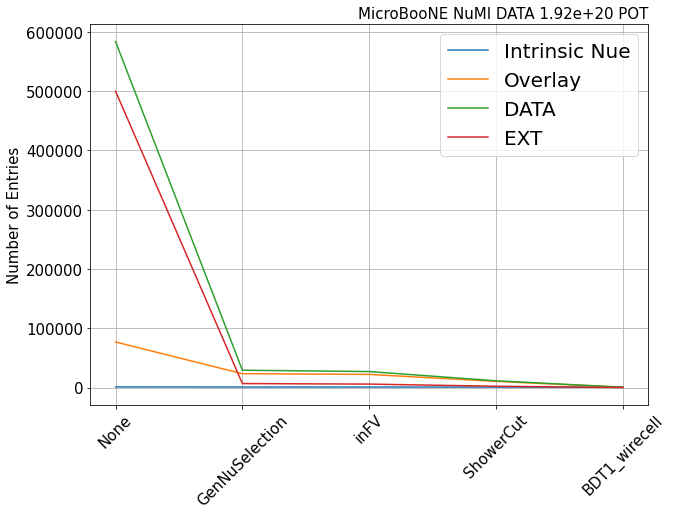

In [8]:
# --- plot the number of entries throughout the pre-selection cuts (for visual aspect only)

size_letter = 15
plt.close()
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.plot(arr_nentries_x, arr_nentries_nue, label='Intrinsic Nue')
plt.plot(arr_nentries_x, arr_nentries_mc, label='Overlay')
plt.plot(arr_nentries_x, arr_nentries_data, label='DATA')
plt.plot(arr_nentries_x, arr_nentries_ext, label='EXT')
plt.ylabel('Number of Entries', fontsize=size_letter)
plt.title('MicroBooNE NuMI DATA %3.2e POT' % POT_data, loc='right', fontsize=size_letter)
plt.yticks(fontsize=size_letter)
plt.grid()
#ax.set_ylim(0,20000)
ax.set_xticks(arr_nentries_x)
ax.set_xticklabels(arr_nentries_x_label, rotation=+45, fontsize=size_letter)
ax.legend(loc='best', ncol=1, prop={'size': 20})
plt.show()

In [9]:
# check the columns of the dataframe
print(df_overlay.shape)
df_overlay.head(5)

(2328, 52)


,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,numu_cc_flag,nue_score,numu_score,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,run,subrun,event,reco_showerMomentum[0],reco_showerMomentum[1],reco_showerMomentum[2],reco_showerMomentum[3],match_found,stm_eventtype,stm_lowenergy,flash_time,stm_LM,stm_TGM,stm_STM,stm_FullDead,stm_clusterlength,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,truth_NprimPio,truth_isCC,truth_nuPdg,truth_vtxInside,match_completeness_energy,weight_cv,weight_spline,truth_energyInside,weight_genie,weight,vec_targ_vtx_X,vec_targ_vtx_Y,vec_targ_vtx_Z,shower_momentum_X,shower_momentum_Y,shower_momentum_Z,shower_energy,norm_vec_targ_vtx,norm_vec_shower,cos_theta,dist_vtxX,dist_vtxY,dist_vtxZ,dist_vtx
entry,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
83,642.624146,1000.0,0.000000,0.0,8.306011,-0.617358,15.088778,43.398285,714.115845,5949,31,1578,0.489857,0.180555,0.306769,0.605531,True,5,0,15.187500,0,0,0,0,65.477203,15.505140,43.392445,714.057983,0,True,12,True,377.866425,0.000150,0.889128,634.785461,0.000133,0.000024,31402.671875,3359.800781,60814.359375,0.489857,0.180555,0.306769,0.605531,68525.921875,0.605531,0.834939,-0.416362,0.005840,0.057861,0.420404
115,1267.182617,0.0,1074.475342,0.0,13.532986,-0.961174,37.691162,79.561050,623.667969,7054,623,31165,-0.215482,0.027708,1.052803,1.074986,True,5,0,12.546875,0,0,0,0,100.871002,37.800560,79.700562,623.623657,0,True,12,True,913.102539,1.180006,0.988973,1128.320435,1.166994,0.211931,31425.275391,3395.963623,60723.910156,-0.215482,0.027708,1.052803,1.074986,68457.828125,1.074986,0.777985,-0.109398,-0.139511,0.044312,0.182742
196,2333.373535,0.0,2104.545166,0.0,14.097258,-1.129636,127.361404,-100.726791,17.248871,7054,1564,78247,1.310601,0.278906,1.623514,2.105056,True,5,0,15.000000,0,0,0,0,139.783005,127.460342,-101.207085,17.158051,0,True,-12,True,1684.509155,1.000000,0.537835,2317.043945,0.537835,0.097673,31514.945312,3215.675781,60117.492188,1.310601,0.278906,1.623514,2.105056,67953.257812,2.105056,0.977326,-0.098938,0.480293,0.090820,0.498717
293,2176.232910,0.0,610.391907,0.0,12.894648,-0.723109,56.621410,-0.996808,931.400269,7049,305,15294,-0.315317,0.054081,0.520435,0.610903,True,5,0,13.875000,0,0,0,0,84.763496,56.721855,-1.148862,931.516663,1,True,12,True,1141.811646,1.000000,0.445587,2395.371582,0.445587,0.080920,31444.205078,3315.405762,61031.640625,-0.315317,0.054081,0.520435,0.610903,68735.664062,0.610903,0.524578,-0.100445,0.152055,-0.116394,0.216234
331,816.141418,0.0,539.916626,0.0,10.388133,0.271326,20.682348,58.108086,459.769440,7054,82,4128,0.510741,0.316917,0.210499,0.645575,True,5,0,6.937500,0,0,0,0,61.978100,21.013023,58.321415,459.671814,0,True,12,True,541.776855,4.778428,0.664413,761.458496,3.174848,0.576566,31408.265625,3374.510742,60560.011719,0.510741,0.316917,0.210499,0.645575,68303.601562,0.636870,0.686401,-0.330675,-0.213329,0.097626,0.405446


In [10]:
# --- check the number of entries of each kind that survived to the pre-selection cuts

print('If the distribution for the overlay and for the intrinsic nue are similar, it means that the pre-selection cuts did a good job removing the non-nue/antinue background from the overlay sample.\n')

def print_nentries(df, label):
    
    df_antinue = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)]
    df_nue = df[(df.truth_nuPdg==12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)]
    
    # remove df_antinue and df_nue from the input df
    df_rest = delete_dataframe(df,df_antinue)
    df_rest = delete_dataframe(df_rest, df_nue)
    
    ratio = 0
    if(label=='MC'): ratio = ratio_mc
    elif(label=='NUE'): ratio = ratio_nue
        
    print('[%s]:' % label)
    print('> nue        %6i (absolute)  | %6i (DATA POT normalised)  | %6.2f%%' % (len(df_nue), len(df_nue)*ratio, 100*len(df_nue)/len(df)))
    print('> antinue    %6i (absolute)  | %6i (DATA POT normalised)  | %6.2f%%' % (len(df_antinue), len(df_antinue)*ratio, 100*len(df_antinue)/len(df)))
    print('> rest       %6i (absolute)  | %6i (DATA POT normalised)  | %6.2f%%' % (len(df_rest), len(df_rest)*ratio, 100*len(df_rest)/len(df)))
    print('')
    
print_nentries(df_overlay, 'MC')
print_nentries(df_intrinsic_nue, 'NUE')

If the distribution for the overlay and for the intrinsic nue are similar, it means that the pre-selection cuts did a good job removing the non-nue/antinue background from the overlay sample.

[MC]:
> nue          1681 (absolute)  |    305 (DATA POT normalised)  |  72.21%
> antinue       412 (absolute)  |     74 (DATA POT normalised)  |  17.70%
> rest          235 (absolute)  |     42 (DATA POT normalised)  |  10.09%

[NUE]:
> nue         38516 (absolute)  |    327 (DATA POT normalised)  |  80.43%
> antinue      8923 (absolute)  |     75 (DATA POT normalised)  |  18.63%
> rest          448 (absolute)  |      3 (DATA POT normalised)  |   0.94%



# Electron Antineutrino BDT

This part of the code is inspired by Davio's code: https://github.com/LArbys/1L1PSelection/blob/davio_june4update/DL_BDTTraining_1mu1p-prime.ipynb

Joshua Mills, Nick Kamp and Ran Itay are MicroBooNE BDT experts good to talk to

In [11]:
def calc_particle_multiplicity(filename):
    
    # this function is only used for the second BDT
    
    # ===================== #
    # PARTICLE MULTIPLICITY #
    # ===================== #

    # --- open file and variables
    
    pfeval_particle = ['reco_mother','reco_pdg','reco_Ntrack', 'run', 'subrun', 'event']
    T_PFeval = uproot.open(filename)['wcpselection/T_PFeval']
    DF = T_PFeval.pandas.df(pfeval_particle, flatten=True)
    
    # --- queries to split into different variables
    
    df_Neutron = DF.query('((reco_pdg==2112) | (reco_pdg==-2112)) & reco_mother==0')
    DF.loc[:,'countNeutron'] = df_Neutron.groupby(['entry'])['reco_pdg'].transform('count')

    df_Muon = DF.query('((reco_pdg==13) | (reco_pdg==-13)) & reco_mother==0')
    DF.loc[:,'countMuon'] = df_Muon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Kaon = DF.query('((reco_pdg==321) | (reco_pdg==-321)) & reco_mother==0')
    DF.loc[:,'countKaon'] = df_Kaon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Pion = DF.query('((reco_pdg==211) | (reco_pdg==-211)) & reco_mother==0')
    DF.loc[:,'countNeutron'] = df_Pion.groupby(['entry'])['reco_pdg'].transform('count')

    df_Proton = DF.query('((reco_pdg==2212) | (reco_pdg==-2212)) & reco_mother==0')
    DF.loc[:,'countProton'] = df_Proton.groupby(['entry'])['reco_pdg'].transform('count')

    df_Gamma = DF.query('((reco_pdg==22) | (reco_pdg==-22)) & reco_mother==0')
    DF.loc[:,'countGamma'] = df_Gamma.groupby(['entry'])['reco_pdg'].transform('count')

    df_Electron = DF.query('((reco_pdg==11) | (reco_pdg==-11)) & reco_mother==0')
    DF.loc[:,'countElectron'] = df_Electron.groupby(['entry'])['reco_pdg'].transform('count')
    
    # --- concat everything together
    
    #df_concat = pd.concat([DF,df_Neutron,df_Muon,df_Kaon,df_Pion,df_Proton,df_Gamma,df_Electron], axis=1)
    #df_concat = df_concat.loc[:,~df_concat.columns.duplicated()]
    
    df_concat = DF
    
    # --- create an extra column with the max number in the count... column
    
    df_concat.loc[:,'Num_Neutron'] = df_concat.groupby(['entry'])['countNeutron'].transform(max)
    df_concat.loc[:,'Num_Muon'] = df_concat.groupby(['entry'])['countMuon'].transform(max)
    df_concat.loc[:,'Num_Kaon'] = df_concat.groupby(['entry'])['countKaon'].transform(max)
    df_concat.loc[:,'Num_Proton'] = df_concat.groupby(['entry'])['countProton'].transform(max)
    df_concat.loc[:,'Num_Gamma'] = df_concat.groupby(['entry'])['countGamma'].transform(max)
    df_concat.loc[:,'Num_Electron'] = df_concat.groupby(['entry'])['countElectron'].transform(max)
    
    # --- get the first subentry only --> the same as unflatten the dataframe
    
    df_concat.groupby('entry').first()
    
    # --- create the final dataframe with the columns that we want
    
    df_final = df_concat[['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron', 'run', 'subrun', 'event']].groupby('entry').first()
    df_final = df_final.fillna(0)
    
    # --- return final dataframe
    
    return df_final

### ADD PARTICLE MULTIPLICITY

In [12]:
# --- create dataframes with the particle multiplicity information, the file must contain the particle flow information for that
df_overlay_multiplicity = calc_particle_multiplicity(mcfile)
df_intrinsic_nue_multiplicity = calc_particle_multiplicity(intrinsicfile)
#df_data_multiplicity = calc_particle_multiplicity(datafile)
#df_ext_multiplicity = calc_particle_multiplicity(extfile)
#df_dirt_multiplicity = calc_particle_multiplicity(dirtfile)

# --- merge the dataframe with the particle multiplicity information, and the dataframe with the events after the selection cuts
#     which means that we're just adding Num_Neutron, Num_Muon, Num_Kaon, Num_Proton, Num_Gamma, Num_Electron columns to the dataframe
#     according to their RSE
df_overlay = pd.merge(df_overlay, df_overlay_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
df_intrinsic_nue = pd.merge(df_intrinsic_nue, df_intrinsic_nue_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
#df_data = pd.merge(df_data, df_data_multipliticy, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
#df_ext = pd.merge(df_ext, df_ext_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
#df_dirt = pd.merge(df_dirt, df_dirt_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')

In [13]:
# check if particle multiplicity was properly added/calculated
# we're adding 6 columns (Num_Neutron, Num_Muon, Num_Kaon, Num_Proton, Num_Gamma, Num_Electron)
print(df_overlay.shape)
print(df_intrinsic_nue.shape)
#df_overlay.head(5) # uncomment to check if the columns were correctly added to the dataframe

(2328, 58)
(47887, 58)


### DEFINE SIGNAL AND BACKGROUND

In [14]:
# --- define the dataframe that will be used for the second BDT
df_bdt = pd.concat([df_intrinsic_nue,df_overlay], ignore_index=True) # merge intrinsic nue + overlay for a better nue/antinue stat

def isSignal(df):
    df_ = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1)]        # antinueCC
    df_ = df_[df_.dist_vtx<1]                                   # good vertex reconstruction, less than 1 cm apart
    df_ = notCosmic(df_)                                        # good event reconstruction, not labelled as cosmic
    return df_

def isBackground(df1, df2):
    # background is everything that is not signal
    # df1 = full dataframe
    # df2 = signal dataframe
    df_ = delete_dataframe(df1, df2)
    return df_

df_signal = isSignal(df_bdt)
df_background = isBackground(df_bdt, df_signal)

if((len(df_signal)+len(df_background))!=(len(df_bdt))): print('   > Ooops! Check your signal/background definition!')
    
print(df_bdt.shape)

(50215, 58)


### START BDT TRAINING

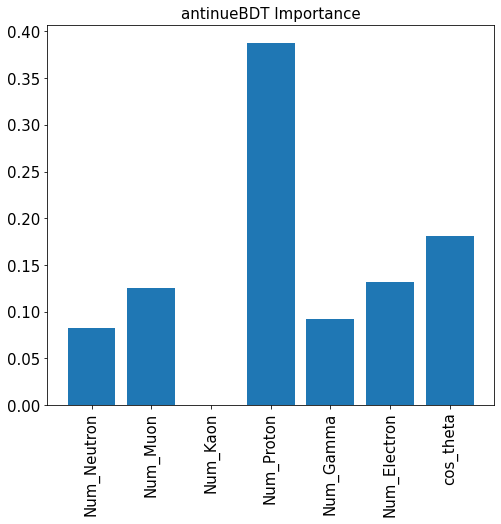

Accuracy = fraction of the time the BDT classifies an object correctly!
Accuracy Test:   83.31895121141719
Accuracy Train:  83.79800853485064
TestAcc - TrainAcc =  -0.47905732343345164


In [15]:
myvars = ['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron','cos_theta']

X = df_signal[myvars].values.tolist()
Y_cos = df_background[myvars].values.tolist()

Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.3 # play around with this number?
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]

antinueBDT = XGBClassifier(#silent = False,
                           scale_pos_weight = 1,
                           learning_rate = 0.01,
                           colsample_bytree = 0.8,
                           objective = 'binary:logistic',
                           subsample = 0.8,
                           n_estimators = 1000,
                           max_depth = 6,
                           gamma = 5,
                           use_label_encoder=False)

antinueBDT.fit(x_train, y_train, eval_metric = ['auc', 'error']) # fit bdt to data

y_checkV = antinueBDT.predict(x_test)
y_checkT = antinueBDT.predict(x_train)

predictionsV = [round(value) for value in y_checkV]
predictionsT = [round(value) for value in y_checkT]
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100.

fig,ax = plt.subplots(figsize=(8,7))
ax.set_title('antinueBDT Importance', fontsize=size_letter)
plt.bar(range(len(antinueBDT.feature_importances_)), antinueBDT.feature_importances_)
plt.xticks(range(len(antinueBDT.feature_importances_)), myvars, rotation='vertical', fontsize=size_letter)
plt.yticks(fontsize=size_letter)
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100.
print('Accuracy = fraction of the time the BDT classifies an object correctly!')
print("Accuracy Test:  ",acc_test*100)
print("Accuracy Train: ",acc_train*100)
print("TestAcc - TrainAcc = ",accuracy_diff)

In [16]:
# --- calculate antinue_score and save it in the dataframes

df_overlay.loc[:,'antinue_score'] = antinueBDT.predict_proba(df_overlay[myvars])[:,1]
df_intrinsic_nue.loc[:,'antinue_score'] = antinueBDT.predict_proba(df_intrinsic_nue[myvars])[:,1]
#df_data.loc[:,'antinue_score'] = antinueBDT.predict_proba(df_data[myvars])[:,1]
#df_ext.loc[:,'antinue_score'] = antinueBDT.predict_proba(df_ext[myvars])[:,1]
#df_dirt.loc[:,'antinue_score'] = antinueBDT.predict_proba(df_dirt[myvars])[:,1]

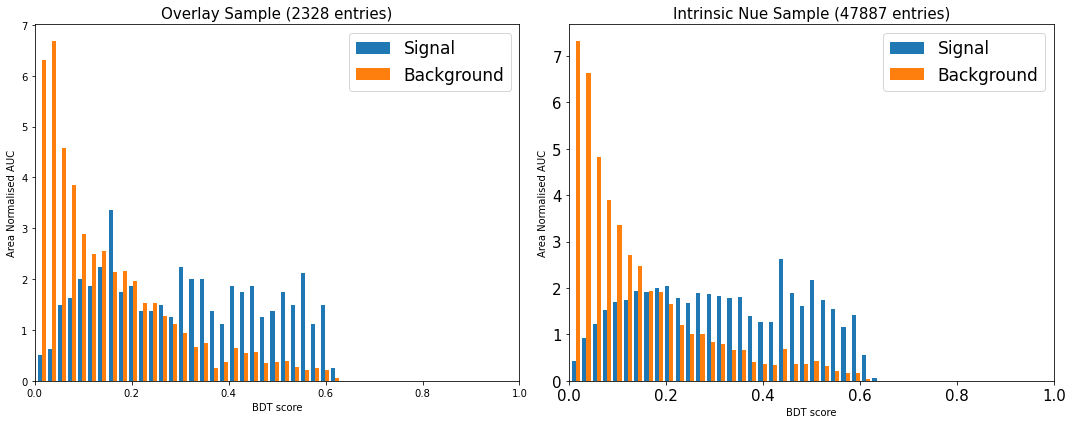

In [17]:
# ========================== #
#   BDT SCORE DISTRIBUTION   #
# ========================== #

df_overlay_sig = isSignal(df_overlay)
df_overlay_bkg = delete_dataframe(df_overlay, df_overlay_sig)

df_intrinsic_nue_sig = isSignal(df_intrinsic_nue)
df_intrinsic_nue_bkg = delete_dataframe(df_intrinsic_nue, df_intrinsic_nue_sig) 
    
hist_list = [df_overlay_sig.antinue_score, df_overlay_bkg.antinue_score]
hist_list2 = [df_intrinsic_nue_sig.antinue_score, df_intrinsic_nue_bkg.antinue_score]
label_list = ['Signal', 'Background']

plt.close()
fig, axs = plt.subplots(1,2,figsize=(15,6))

axs[0].hist(hist_list, label=label_list, bins=30, density=True) # density=True (histogram integral = 1)
axs[0].legend(loc='best', ncol=1, prop={'size': 17})
axs[0].set_title('Overlay Sample (%i entries)' % len(df_overlay), fontsize=size_letter)
axs[0].set_xlabel('BDT score')
axs[0].set_ylabel('Area Normalised AUC')
axs[0].set_xlim(0,1)

axs[1].hist(hist_list2, label=label_list, bins=30, density=True) # density=True (histogram integral = 1)
axs[1].legend(loc='best', ncol=1, prop={'size': 17})
axs[1].set_title('Intrinsic Nue Sample (%i entries)' % len(df_intrinsic_nue), fontsize=size_letter)
axs[1].set_xlabel('BDT score')
axs[1].set_ylabel('Area Normalised AUC')
axs[1].set_xlim(0,1)

plt.yticks(fontsize=size_letter)
plt.xticks(fontsize=size_letter)

plt.tight_layout()
plt.show()

# Comments: 
#      (1) This is the distribution of the BDT score for the overlay and the intrinsic nue samples.
#          Note that they have a very similar shape, and this is because our pre-selection cuts did
#          an excellent job removing non nue background from the overlay sample. So both samples look
#          very similar after the pre-selection cuts, the overlay one has a much smaller stat which
#          explains the fluctiations.
#      (2) The number of entries in the title is the absolute number of entries in each dataframe.
#          Should I always display the DATA POT normalised number of entries for this kind of plot?

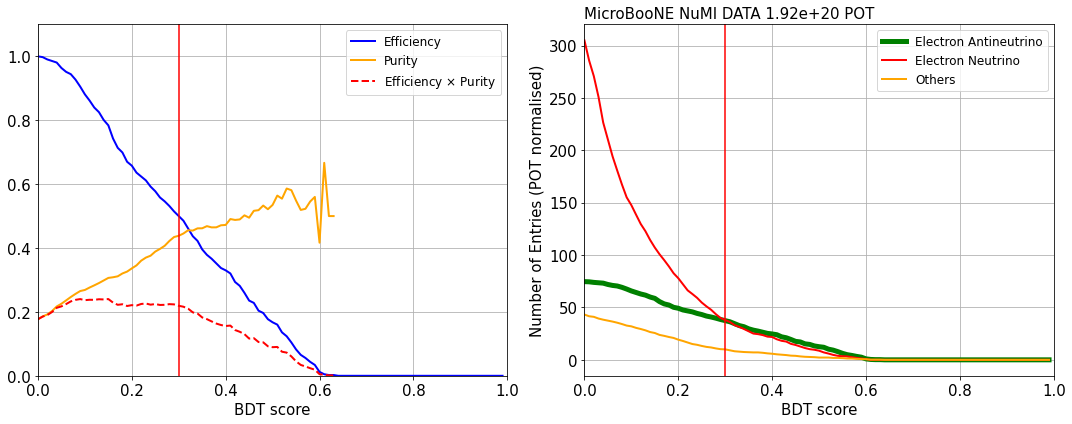

In [18]:
# ========================= #
#   PURITY AND EFFICIENCY   #
# ========================= #

arr_pur = []
arr_pur_x = []
arr_eff = []
arr_eff_x = []
arr_mult = [] # purity x efficiency
arr_mult_x = [] 

arr_nentries_antinue = []
arr_nentries_nue = []
arr_nentries_others = []
arr_nentries_x = []

step = 0.01           # choose the step
df = df_overlay       # choose which dataframe to use

var = 0
while(var <= 1):
    
    eff = -999
    pur = -999
    
    # --- efficiency
    df_eff_num = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    df_eff_num = apply_gen_nu_selection(df_eff_num)
    df_eff_den = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)]
    if(len(df_eff_den)!=0):
        eff = len(df_eff_num)/len(df_eff_den)
        arr_eff.append(eff)
        arr_eff_x.append(var)
        
    # --- purity
    df_pur_num = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    df_pur_den = df[df.antinue_score>var]
    if(len(df_pur_den)!=0):
        pur = len(df_pur_num)/len(df_pur_den)
        arr_pur.append(pur)
        arr_pur_x.append(var)
        
    # --- purity x efficiency
    if((eff!=-999) & (pur!=-999)):
        arr_mult.append(pur*eff)
        arr_mult_x.append(var)
        
    # --- nentries
    df_antinue = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    df_antinue = notCosmic(df_antinue)
    df_nue = df[(df.truth_nuPdg==12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    df_nue = notCosmic(df_nue)
    
    df_rest = delete_dataframe(df, df_antinue) 
    df_rest = delete_dataframe(df_rest, df_nue)
    df_rest = df_rest[df_rest.antinue_score>var]
    
    nentries_antinue = len(df_antinue) * (POT_data/POT_mc)
    nentries_nue = len(df_nue) * (POT_data/POT_mc)
    nentries_rest = len(df_rest) * (POT_data/POT_mc)
    
    arr_nentries_antinue.append(nentries_antinue)
    arr_nentries_nue.append(nentries_nue)
    arr_nentries_others.append(nentries_rest)
    arr_nentries_x.append(var)
    
    var = var + step
        
# --- now that we have the arrays, let's plot them :)

plt.close()
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(arr_eff_x, arr_eff, c='blue', label='Efficiency', linewidth=2.0)
plt.plot(arr_pur_x, arr_pur, c='orange', label='Purity', linewidth=2.0)
plt.plot(arr_mult_x, arr_mult, c='red', linestyle='dashed', label=r'Efficiency $\times$ Purity', linewidth=2.0)
plt.grid()
plt.ylim([0,1.1])
plt.xlim([0,1])
plt.xlabel('BDT score', fontsize=size_letter)
plt.legend(loc='best', prop={'size': 12})
plt.yticks(fontsize=size_letter)
plt.xticks(fontsize=size_letter)

plt.subplot(122)
plt.plot(arr_nentries_x, arr_nentries_antinue, c='green', label="Electron Antineutrino", linewidth=5.0)
plt.plot(arr_nentries_x, arr_nentries_nue, c='red', label="Electron Neutrino", linewidth=2.0)
plt.plot(arr_nentries_x, arr_nentries_others, c='orange', label="Others", linewidth=2.0)
plt.grid()
plt.xlim([0,1])
plt.xlabel('BDT score', fontsize=size_letter)
plt.ylabel('Number of Entries (POT normalised)', fontsize=size_letter)
plt.title('MicroBooNE NuMI DATA %.2e POT' % POT_data, loc='left', fontsize=size_letter)
plt.legend(loc='best', prop={'size': 12})
plt.yticks(fontsize=size_letter)
plt.xticks(fontsize=size_letter)

# ================= #
#   DRAW BDT CUT?   #
# ================= #

if(True):
    antinue_score_cut = 0.3
    plt.subplot(121)
    plt.axvline(x=antinue_score_cut, color='r')
    plt.subplot(122)
    plt.axvline(x=antinue_score_cut, color='r')

plt.tight_layout()
plt.show()

# Comments:
#      (1) When the signal and background is very similar, the BDT has a hard time to distinguish them, and for this reason
#          our BDT score distribution only goes up to 0.6, because nue and antinue events are basically the same in the LArTPC
#          so we should not worry about the fact that it goes up to 0.6. It's expected :)
#      (2) The cut at 0.3 was done by eye for now. This is something that can be optimised later on.

### APPLY BDT CUT

In [19]:
antinue_score_cut = 0.3

BDT cut = 0.30

Above the cut: 85 events
> antinue    35
> nue        34
> rest       14

Below the cut: 337 events
> antinue    33
> nue       248
> rest       55


/tmp/ipykernel_26181/1781538113.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=size_letter)


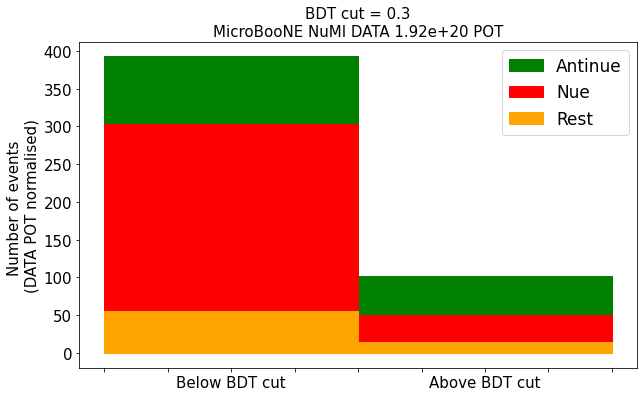

In [20]:
# --- create dataframes for above and below the bdt cut

df_above = df_overlay[df_overlay.antinue_score>=antinue_score_cut]
df_below = df_overlay[df_overlay.antinue_score<antinue_score_cut]

# --- split the dataframes above into signal and background, and calculate purity=signal/total

df_above_sig = isSignal(df_above)
df_above_bkg = delete_dataframe(df_above, df_above_sig)
purity_above = len(df_above_sig)/len(df_above)

df_below_sig = isSignal(df_below)
df_below_bkg = delete_dataframe(df_below, df_below_sig)
purity_below = len(df_below_sig)/len(df_below)

ratio = POT_data/POT_mc # = POT_data/POT_mc for DATA POT normalised numbers, = 1 for absolute numbers

def calc_antinue_nue_rest(df):
    
    df_antinue = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.dist_vtx<1)]
    df_antinue = notCosmic(df_antinue)
    
    df_nue = df[(df.truth_nuPdg==12) & (df.truth_isCC==1) & (df.dist_vtx<1)]
    df_nue = notCosmic(df_nue)
    
    df_rest = delete_dataframe(df, df_antinue)
    df_rest = delete_dataframe(df_rest, df_nue)
    
    n_antinue = len(df_antinue)
    n_nue = len(df_nue)
    n_rest = len(df_rest)
    
    return n_antinue, n_nue, n_rest

n_antinue_above, n_nue_above, n_rest_above = calc_antinue_nue_rest(df_above)
n_antinue_below, n_nue_below, n_rest_below = calc_antinue_nue_rest(df_below)
    
print('BDT cut = %.2f' % antinue_score_cut)
print('\nAbove the cut: %i events' % (len(df_above)*ratio))
print('> antinue  %4i' % (n_antinue_above*ratio))
print('> nue      %4i' % (n_nue_above*ratio))
print('> rest     %4i' % (n_rest_above*ratio))
print('\nBelow the cut: %i events' % (len(df_below)*ratio))
print('> antinue  %4i' % (n_antinue_below*ratio))
print('> nue      %4i' % (n_nue_below*ratio))
print('> rest     %4i' % (n_rest_below*ratio))

# ========= #
# make plot #
# ========= #

ratio = ratio_mc
antinue = np.array([0, n_antinue_below*ratio, n_antinue_above*ratio])
nue = np.array([0, n_nue_below*ratio, n_antinue_above*ratio])
rest = np.array([0, n_rest_below*ratio, n_rest_above*ratio])

rest = rest # bottom
nue = rest + nue # middle
antinue = rest + nue + antinue # top

x = [0,1,2]
plt.close()
fig, ax = plt.subplots(figsize=(10,6))
plt.title('BDT cut = %.1f\nMicroBooNE NuMI DATA %.2e POT' % (antinue_score_cut, POT_data), fontsize=size_letter)
plt.fill_between(x, antinue, label='Antinue', step="pre", color='green')
plt.fill_between(x, nue, label='Nue', step="pre", color='red')
plt.fill_between(x, rest, label='Rest', step="pre", color='orange')
plt.legend(loc='best', ncol=1, prop={'size': 17})
plt.yticks(fontsize=size_letter)
plt.ylabel('Number of events \n(DATA POT normalised)', fontsize=size_letter)
labels= [item.get_text() for item in ax.get_xticklabels()]
labels[3] = 'Below BDT cut'
labels[7] = 'Above BDT cut'
ax.set_xticklabels(labels, fontsize=size_letter)
plt.show()

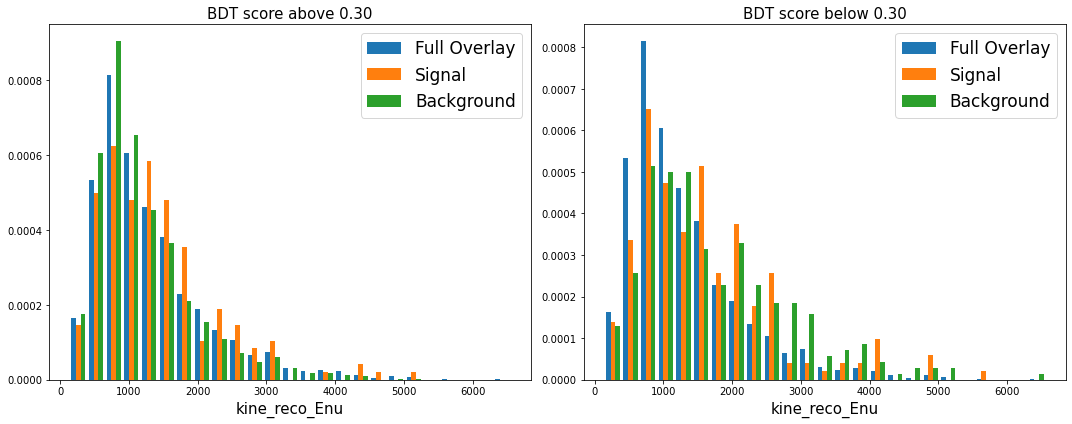

In [21]:
# plot energy distribution for nue and antinue for above and below cut

var = 'kine_reco_Enu' # truth_energyInside

hist_list_above = [df_overlay[var], df_above_sig[var], df_above_bkg[var]]
hist_list_below = [df_overlay[var], df_below_sig[var], df_below_bkg[var]]
label_list = ['Full Overlay', 'Signal', 'Background']

plt.close()
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.hist(hist_list_below, label=label_list, bins=25, density=True)
plt.legend(loc='best', ncol=1, prop={'size': 17})
plt.xlabel('%s' % var,fontsize=size_letter)
plt.title('BDT score above %.2f' % antinue_score_cut, fontsize=size_letter)

plt.subplot(122)
plt.hist(hist_list_above, label=label_list, bins=25, density=True)
plt.legend(loc='best', ncol=1, prop={'size': 17})
plt.xlabel('%s' % var, fontsize=size_letter)
plt.title('BDT score below %.2f' % antinue_score_cut, fontsize=size_letter)

plt.tight_layout()
plt.show()

# Comments: this plot shows if our bdt score cut changes the energy distribution of our selected sample
#           it looks like it's all good, the overall shape remains the same

# Exploring Proton Multiplicity

This part of the code makes a bunch of plots comparing antinue and nue+rest, which is basically only showing that they have indeed very similar behaviours.

In [22]:
print(df_overlay.shape)
#df_overlay.head(5)

(2328, 59)


In [23]:
# in order to explore the proton multiplicity, we have to create new (flatten) dataframes with the information of all the daughter particles

def calc_proton_direction(file, df_list):
    
    # this function calculated the daughter particles direction wrt the beam, so the output is going to be a flatten dataframe with
    # many information about the daughter particles. To be able to do that, we create the dataframe from the input root file, from
    # the beginning of the code, which contains ALL the events in the root file. This function only keeps the events in df_list. For
    # example, if you want to keep the events that passed the pre-selection cuts, make df_list=df_overlay, because df_overlay is the
    # dataframe for the overlay sample that passed all the pre-selection cuts. I hope it makes sense :)
    
    # =================================================== #
    # CREATE DATAFRAME WITH THE PARTICLE FLOW INFORMATION #
    # =================================================== #
    
    # --- variables that we want to import from the input file
    
    pfeval_particle = ['run', 'subrun', 'event', 'reco_startXYZT', 'reco_endXYZT', 'reco_pdg', 'reco_mother','reco_Ntrack'] 
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    DF_PFeval = T_PFeval.pandas.df(pfeval_particle, flatten=True)
        
    DF_ = DF_PFeval
    
    # --- only keep RSE in df_list
    
    df_ = df_list.copy()                                                                                      # create a copy to avoid warning messages   
    df_['temp_ID'] = df_['run'].apply(str) +"_"+ df_['subrun'].apply(str) +"_"+ df_['event'].apply(str)       # create a new column of run_subrun_event
    
    DF_['temp_ID'] = DF_['run'].apply(str) +"_"+ DF_['subrun'].apply(str) +"_"+ DF_['event'].apply(str)       # create a new column of run_subrun_event
    
    DF_filtered = DF_[DF_.temp_ID.isin(df_.temp_ID)]                                                          # only keep the events in DF_ that exist in df_
    DF_filtered = DF_filtered.query('reco_mother==0')                                                         # only keep daughter particles with a neutrino as a mother
    DF = DF_filtered.copy()                                                                                   # create a copy to avoid warning messages when using .loc[]
    
    # --- fixing the name of the variables
    
    DF.loc[:,'part_startX'] = DF["reco_startXYZT[0]"]
    DF.loc[:,'part_startY'] = DF["reco_startXYZT[1]"]
    DF.loc[:,'part_startZ'] = DF["reco_startXYZT[2]"]
    DF.loc[:,'part_startT'] = DF["reco_startXYZT[3]"]
    DF.loc[:,'part_endX'] = DF["reco_endXYZT[0]"]
    DF.loc[:,'part_endY'] = DF["reco_endXYZT[1]"]
    DF.loc[:,'part_endZ'] = DF["reco_endXYZT[2]"]
    DF.loc[:,'part_endT'] = DF["reco_endXYZT[3]"]
    
    # --- calculate the particle momenta in each direction
    
    DF = DF.eval('part_momX = part_endX - part_startX')
    DF = DF.eval('part_momY = part_endY - part_startY')
    DF = DF.eval('part_momZ = part_endZ - part_startZ')
    
    # --- calculate cos_theta of the proton wrt the beam direction
        
    DF.eval('vec_targ_proton_vtx_X = part_startX - (-31387.58422)', inplace=True)
    DF.eval('vec_targ_proton_vtx_Y = part_startY - (-3316.402543)', inplace=True)
    DF.eval('vec_targ_proton_vtx_Z = part_startZ - (-60100.2414)', inplace=True)
    
    DF.eval('norm_vec_targ_proton_vtx = sqrt(vec_targ_proton_vtx_X**2 + vec_targ_proton_vtx_Y**2 + vec_targ_proton_vtx_Z**2)', inplace=True)
    DF.eval('norm_vec_proton = sqrt(part_momX**2 + part_momY**2 + part_momZ**2)', inplace=True)
    
    DF.eval('cos_theta_proton = ((vec_targ_proton_vtx_X * part_momX) + (vec_targ_proton_vtx_Y * part_momY) + (vec_targ_proton_vtx_Z * part_momZ) )/(norm_vec_targ_proton_vtx * norm_vec_proton)', inplace=True)   
    
    # --- drop the columns that we don't want to save in our dataframe (just to save memory)
    
    DF.drop(['vec_targ_proton_vtx_X', 'vec_targ_proton_vtx_Y', 'vec_targ_proton_vtx_Z'], axis='columns', inplace=True)
    
    # ============================================== #
    # MERGE THE CREATED DATAFRAME WITH THE INPUT ONE #
    # ============================================== #
    
    # the idea is to add the new variables to the input dataframe, so let's merge them
    
    DF_final = pd.merge(df_list, DF, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
    
    return DF_final
    
df_overlay_new = calc_proton_direction(mcfile, df_overlay)

In [24]:
print(df_overlay_new.shape)
df_overlay_new.head(5)

(11497, 85)


,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,numu_cc_flag,nue_score,numu_score,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,run,subrun,event,reco_showerMomentum[0],reco_showerMomentum[1],reco_showerMomentum[2],reco_showerMomentum[3],match_found,stm_eventtype,stm_lowenergy,flash_time,stm_LM,stm_TGM,stm_STM,stm_FullDead,stm_clusterlength,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,truth_NprimPio,truth_isCC,truth_nuPdg,truth_vtxInside,match_completeness_energy,weight_cv,weight_spline,truth_energyInside,weight_genie,weight,vec_targ_vtx_X,vec_targ_vtx_Y,vec_targ_vtx_Z,shower_momentum_X,shower_momentum_Y,shower_momentum_Z,shower_energy,norm_vec_targ_vtx,norm_vec_shower,cos_theta,dist_vtxX,dist_vtxY,dist_vtxZ,dist_vtx,Num_Neutron,Num_Muon,Num_Kaon,Num_Proton,Num_Gamma,Num_Electron,antinue_score,reco_startXYZT[0],reco_startXYZT[1],reco_startXYZT[2],reco_startXYZT[3],reco_endXYZT[0],reco_endXYZT[1],reco_endXYZT[2],reco_endXYZT[3],reco_pdg,reco_mother,reco_Ntrack,temp_ID,part_startX,part_startY,part_startZ,part_startT,part_endX,part_endY,part_endZ,part_endT,part_momX,part_momY,part_momZ,norm_vec_targ_proton_vtx,norm_vec_proton,cos_theta_proton
0,642.624146,1000.0,0.000000,0.0,8.306011,-0.617358,15.088778,43.398285,714.115845,5949,31,1578,0.489857,0.180555,0.306769,0.605531,True,5,0,15.187500,0,0,0,0,65.477203,15.50514,43.392445,714.057983,0,True,12,True,377.866425,0.000150,0.889128,634.785461,0.000133,0.000024,31402.671875,3359.800781,60814.359375,0.489857,0.180555,0.306769,0.605531,68525.921875,0.605531,0.834939,-0.416362,0.005840,0.057861,0.420404,0.0,0.0,0.0,0.0,0.0,1.0,0.281829,15.088778,43.398285,714.115845,0.0,102.458961,80.503090,798.787598,0.0,11,0,33,5949_31_1578,15.088778,43.398285,714.115845,0.0,102.458961,80.503090,798.787598,0.0,87.370186,37.104805,84.671753,68525.921875,127.199142,0.919823
1,642.624146,1000.0,0.000000,0.0,8.306011,-0.617358,15.088778,43.398285,714.115845,5949,31,1578,0.489857,0.180555,0.306769,0.605531,True,5,0,15.187500,0,0,0,0,65.477203,15.50514,43.392445,714.057983,0,True,12,True,377.866425,0.000150,0.889128,634.785461,0.000133,0.000024,31402.671875,3359.800781,60814.359375,0.489857,0.180555,0.306769,0.605531,68525.921875,0.605531,0.834939,-0.416362,0.005840,0.057861,0.420404,0.0,0.0,0.0,0.0,0.0,1.0,0.281829,15.088778,43.398285,714.115845,0.0,15.744387,46.215820,718.978638,0.0,2112,0,33,5949_31_1578,15.088778,43.398285,714.115845,0.0,15.744387,46.215820,718.978638,0.0,0.655608,2.817535,4.862793,68525.921875,5.658187,0.840223
2,642.624146,1000.0,0.000000,0.0,8.306011,-0.617358,15.088778,43.398285,714.115845,5949,31,1578,0.489857,0.180555,0.306769,0.605531,True,5,0,15.187500,0,0,0,0,65.477203,15.50514,43.392445,714.057983,0,True,12,True,377.866425,0.000150,0.889128,634.785461,0.000133,0.000024,31402.671875,3359.800781,60814.359375,0.489857,0.180555,0.306769,0.605531,68525.921875,0.605531,0.834939,-0.416362,0.005840,0.057861,0.420404,0.0,0.0,0.0,0.0,0.0,1.0,0.281829,15.088778,43.398285,714.115845,0.0,16.241116,33.997047,740.253784,0.0,2112,0,33,5949_31_1578,15.088778,43.398285,714.115845,0.0,16.241116,33.997047,740.253784,0.0,1.152337,-9.401237,26.137939,68525.921875,27.801134,0.836787
3,642.624146,1000.0,0.000000,0.0,8.306011,-0.617358,15.088778,43.398285,714.115845,5949,31,1578,0.489857,0.180555,0.306769,0.605531,True,5,0,15.187500,0,0,0,0,65.477203,15.50514,43.392445,714.057983,0,True,12,True,377.866425,0.000150,0.889128,634.785461,0.000133,0.000024,31402.671875,3359.800781,60814.359375,0.489857,0.180555,0.306769,0.605531,68525.921875,0.605531,0.834939,-0.416362,0.005840,0.057861,0.420404,0.0,0.0,0.0,0.0,0.0,1.0,0.281829,15.088778,43.398285,714.115845,0.0,9.156530,2.509714,774.166809,0.0,2112,0,33,5949_31_1578,15.088778,43.398285,714.115845,0.0,9.156530,2.509714,774.166809,0.0,-5.932248,-40.888573,60.050964,68525.921875,72.891602,0.666330
4,1267.182617,0.0,1074.475342,0.0,13.532986,-0.961174,37.691162,79.561050,623.667969,7054,623,31165,-0.215482,0.027708,1.052803,1.074986,True,5,0,12.546875,0,0,0

In [25]:
# --- create dataframes for different proton multiplicities, keep only the proton daughter particles

df_1p = df_overlay_new[(df_overlay_new.Num_Proton==1) & (df_overlay_new.reco_pdg==2212)]
df_2p = df_overlay_new[(df_overlay_new.Num_Proton==2) & (df_overlay_new.reco_pdg==2212)]
df_3p = df_overlay_new[(df_overlay_new.Num_Proton==3) & (df_overlay_new.reco_pdg==2212)]
df_4p = df_overlay_new[(df_overlay_new.Num_Proton==4) & (df_overlay_new.reco_pdg==2212)]
df_5p = df_overlay_new[(df_overlay_new.Num_Proton==5) & (df_overlay_new.reco_pdg==2212)]

# --- make sure the index starts at 0 (it will make your life easier to split them later on)

df_1p = df_1p.reset_index()
df_2p = df_2p.reset_index()
df_3p = df_3p.reset_index()
df_4p = df_4p.reset_index()
df_5p = df_5p.reset_index()

# --- create signal and background dataframes

def sig_and_bkg(df):
    df_sig = isSignal(df)
    df_bkg = delete_dataframe(df, df_sig)
    return df_sig, df_bkg

df_sig_1p, df_bkg_1p = sig_and_bkg(df_1p)
df_sig_2p, df_bkg_2p = sig_and_bkg(df_2p)
df_sig_3p, df_bkg_3p = sig_and_bkg(df_3p)
df_sig_4p, df_bkg_4p = sig_and_bkg(df_4p)
df_sig_5p, df_bkg_5p = sig_and_bkg(df_5p)

# --- check number of events per proton multiplicity

ratio = ratio_mc

if(ratio==1): print('Absolute numbers:\n')
else: print('DATA POT normalised numbers:\n')

print('1p   %6i signal   %6i background' % (len(df_sig_1p)*ratio, len(df_bkg_1p)*ratio))
print('2p   %6i signal   %6i background' % (len(df_sig_2p)*ratio/2, len(df_bkg_2p)*ratio/2))
print('3p   %6i signal   %6i background' % (len(df_sig_3p)*ratio/3, len(df_bkg_3p)*ratio/3))
print('4p   %6i signal   %6i background' % (len(df_sig_4p)*ratio/4, len(df_bkg_4p)*ratio/4))
print('5p   %6i signal   %6i background' % (len(df_sig_5p)*ratio/5, len(df_bkg_5p)*ratio/5))

DATA POT normalised numbers:

1p       17 signal      142 background
2p        2 signal       41 background
3p        0 signal        7 background
4p        0 signal        1 background
5p        0 signal        0 background


## 1p events

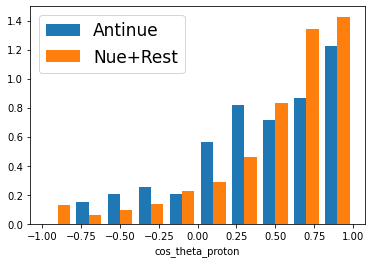

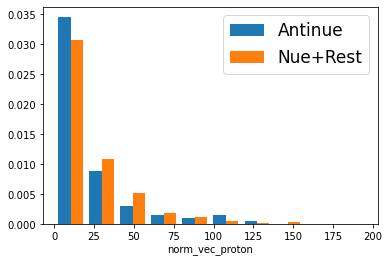

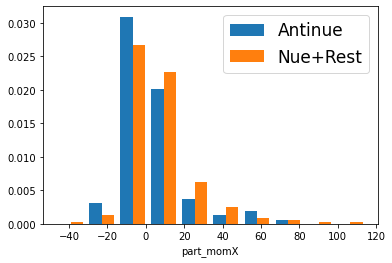

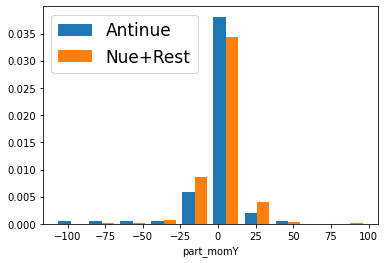

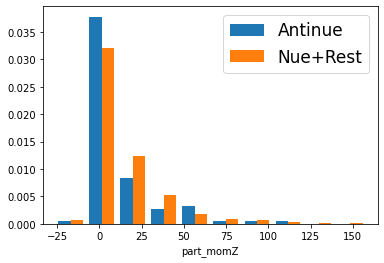

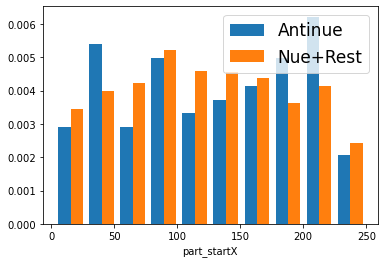

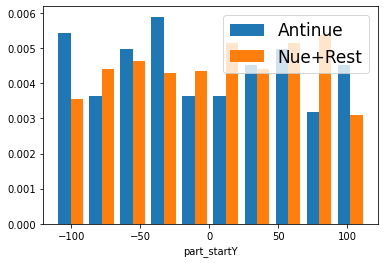

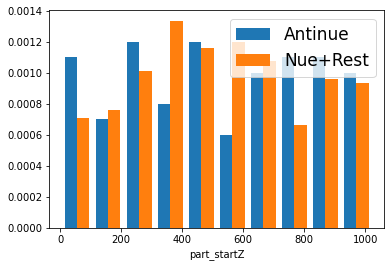

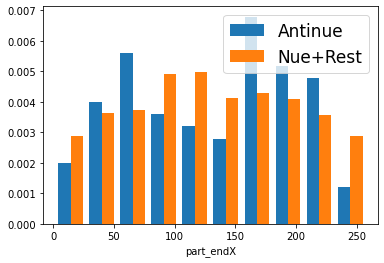

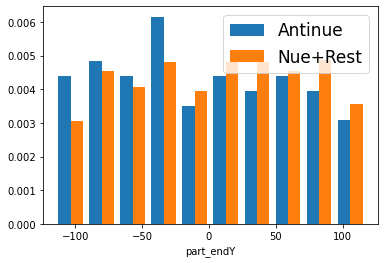

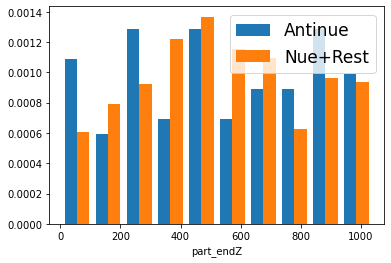

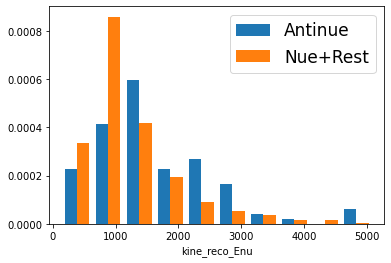

In [26]:
# --- make plots to compare 1p signal vs 1p background

def compare_sig_bkg(df_sig, df_bkg, var):
    
    plt.close()
    
    hist_list = [df_sig[var], df_bkg[var]]
    label_list = ['Antinue', 'Nue+Rest']
    
    plt.hist(hist_list, label=label_list, bins=10, density=True)
    plt.legend(loc='best', ncol=1, prop={'size': 17})
    plt.xlabel('%s' % var)
    
    plt.show()

show_plots = True
if(show_plots == True):
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'cos_theta_proton')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'norm_vec_proton')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_momX')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_momY')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_momZ')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_startX')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_startY')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_startZ')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_endX')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_endY')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'part_endZ')
    compare_sig_bkg(df_sig_1p, df_bkg_1p, 'kine_reco_Enu')

## 2p events

In [27]:
# --- create one dataframe for each proton of the event
df_2p_proton1 = df_2p.iloc[(df_2p.index % 2 == 0).astype(bool)].reset_index(drop=True)
df_2p_proton2 = df_2p.iloc[(df_2p.index % 2 != 0).astype(bool)].reset_index(drop=True)

# --- create a dataframe with the columns in proton_vars
proton_vars = ['run','subrun','event','truth_nuPdg','truth_isCC','dist_vtx','match_completeness_energy','truth_energyInside','cos_theta_proton']
df_2p_proton1_all = df_2p_proton1[proton_vars].copy()
df_2p_proton2_all = df_2p_proton2[proton_vars].copy()

# --- merge the dataframes above, we should end up with a dataframe with a column per each proton information
merging_vars = ['run','subrun','event', 'truth_nuPdg', 'truth_isCC', 'dist_vtx', 'match_completeness_energy','truth_energyInside']
df_2p_all = pd.merge(df_2p_proton1_all, df_2p_proton2_all, left_on=merging_vars, right_on=merging_vars, how='left')

# --- check if everything worked fine
if( (len(df_2p_all)==len(df_2p_proton1_all)) & (len(df_2p_all)==len(df_2p_proton2_all)) ): print('Good work splitting your dataframes!')
else: print('Check your dataframes!')
    
# --- calculate variables
df_2p_all["max_cos_theta"] = df_2p_all[["cos_theta_proton_x", "cos_theta_proton_y"]].max(axis=1) # max cos_theta
df_2p_all["min_cos_theta"] = df_2p_all[["cos_theta_proton_x", "cos_theta_proton_y"]].min(axis=1) # min cos_theta
# calculate angle between protons

Good work splitting your dataframes!


Absolute numbers:
> Signal = 15 events
> Background = 227 events
DATA POT normalised numbers:
> Signal = 2 events
> Background = 41 events


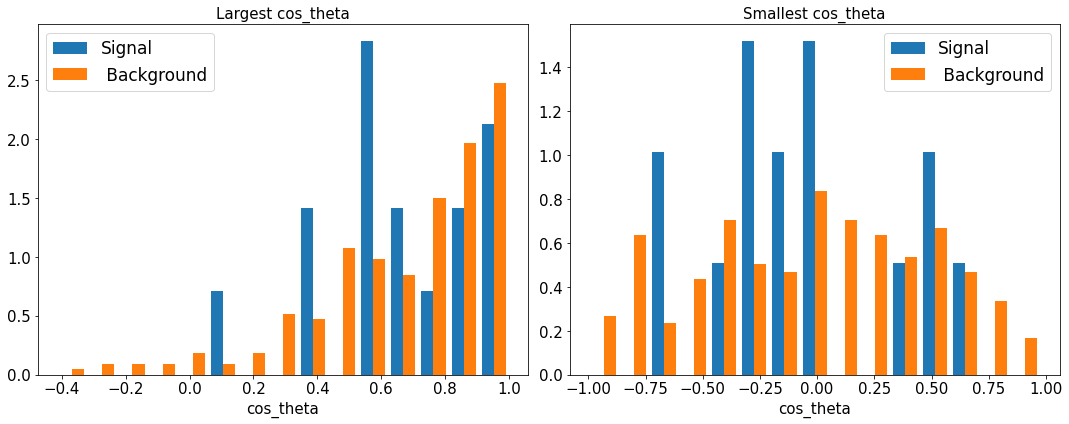

In [28]:
# plot cossine

df_2p_all_sig, df_2p_all_bkg = sig_and_bkg(df_2p_all)
print('Absolute numbers:')
print('> Signal = %i events' % len(df_2p_all_sig))
print('> Background = %i events' % len(df_2p_all_bkg))
print('DATA POT normalised numbers:')
print('> Signal = %i events' % (len(df_2p_all_sig)*ratio_mc))
print('> Background = %i events' % (len(df_2p_all_bkg)*ratio_mc))

plt.close()

plt.figure(figsize=(15,6))

plt.subplot(121)
hist_list = [df_2p_all_sig["max_cos_theta"], df_2p_all_bkg["max_cos_theta"]]
label_list = ['Signal', ' Background']
plt.hist(hist_list, label=label_list, bins=15, density=True)
plt.legend(loc='best', ncol=1, prop={'size': 17})
plt.xlabel('cos_theta', fontsize=size_letter)
plt.xticks(fontsize=size_letter)
plt.yticks(fontsize=size_letter)
plt.title('Largest cos_theta', fontsize=size_letter)

plt.subplot(122)
hist_list = [df_2p_all_sig["min_cos_theta"], df_2p_all_bkg["min_cos_theta"]]
label_list = ['Signal', ' Background']
plt.hist(hist_list, label=label_list, bins=15, density=True)
plt.legend(loc='best', ncol=1, prop={'size': 17})
plt.xlabel('cos_theta', fontsize=size_letter)
plt.xticks(fontsize=size_letter)
plt.yticks(fontsize=size_letter)
plt.title('Smallest cos_theta', fontsize=size_letter)

plt.tight_layout()
plt.show()

In [29]:
# highest energy proton - angle
# pot normalised

In [30]:
# bdt score vs proton_multiplicity, nu energy

In [31]:
# =========== #
#             #
#   KS TEST   #
#             #
# =========== #

In [32]:
# --- explore the properties of the events above the bdt cut
# --- are their distribution the same?

bdt_cut = 0.5

# --- apply the bdt cut
df_bdt = df_overlay[df_overlay.antinue_score>bdt_cut]

# --- split remaining dataframe into signal and background
df_bdt_sig = isSignal(df_bdt)
df_bdg_bkg = delete_dataframe(df_bdt, df_bdt_sig)

# --- plot variables
def plot_2df(df1, df2, label1, label2):
    
    hist_list = [df1[var], df2[var]]
    label_list = [label1, label2]
    
    plt.hist(hist_list, label=label_list, bins=50, density=False)
    plt.legend(loc='best', ncol=1, prop={'size': 17})
    

# cut = 0.5
# check distributions for nue vs antinue